In [ ]:
import torch

In [ ]:
import cv2

In [ ]:
import os

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from tqdm.notebook import tqdm

In [ ]:
epochs = 25
lr = 0.003
image_size = 320
batch_size = 16
encoder = "timm-efficientnet-b5"
weights = 'imagenet'

In [ ]:
import zipfile

In [ ]:
zip_name_gt = "Ground_Truth.zip"
zip_name_img = "Training_Images.zip"

In [ ]:
zf_gt = zipfile.ZipFile(zip_name_gt, 'r')
zf_gt.extractall("Ground_Truth")
zf_gt.close()

In [ ]:
zf_img = zipfile.ZipFile(zip_name_img, 'r')
zf_img.extractall("Training_Images")
zf_img.close()

In [4]:
csv_file = "train.csv"

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
df_1 = df.copy()

In [12]:
df_1['masks'] = df_1['masks'].apply(lambda x: x.replace('Human-Segmentation-Dataset-master/', ''))
df_1['images'] = df_1['images'].apply(lambda x: x.replace('Human-Segmentation-Dataset-master/', ''))

In [13]:
df_1.head()

,masks,images
0,Ground_Truth/1.png,Training_Images/1.jpg
1,Ground_Truth/10.png,Training_Images/10.jpg
2,Ground_Truth/100.png,Training_Images/100.jpg
3,Ground_Truth/101.png,Training_Images/101.jpg
4,Ground_Truth/102.png,Training_Images/102.jpg


In [ ]:
row = df.iloc[1]

In [ ]:
img_path = row['images']
mask_path = row['masks']

In [ ]:
import os

In [ ]:
img_path

'/content/Human-Segmentation-Dataset-master/Training_Images/10.jpg'

In [ ]:
img = cv2.imread(img_path)

array([[[54, 58, 63],
        [55, 59, 64],
        [58, 62, 67],
        ...,
        [77, 86, 90],
        [76, 85, 89],
        [74, 83, 87]],

       [[54, 58, 63],
        [56, 60, 65],
        [59, 63, 68],
        ...,
        [45, 54, 58],
        [44, 53, 57],
        [42, 51, 55]],

       [[56, 60, 65],
        [58, 62, 67],
        [60, 64, 69],
        ...,
        [43, 52, 56],
        [42, 51, 55],
        [39, 48, 52]],

       ...,

       [[54, 49, 50],
        [55, 50, 51],
        [57, 52, 53],
        ...,
        [85, 83, 83],
        [84, 82, 82],
        [84, 82, 82]],

       [[55, 50, 51],
        [56, 51, 52],
        [58, 53, 54],
        ...,
        [79, 77, 77],
        [79, 77, 77],
        [79, 77, 77]],

       [[54, 52, 52],
        [55, 53, 53],
        [57, 55, 55],
        ...,
        [73, 71, 71],
        [72, 70, 70],
        [72, 70, 70]]], dtype=uint8)
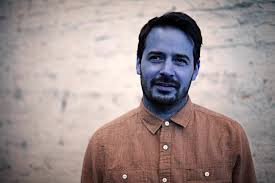

In [ ]:
img

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/ 255

In [ ]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
mask.shape

(183, 275)

In [ ]:
mask = np.expand_dims(mask, axis = -1)

In [ ]:
mask.shape

(183, 275, 1)

In [ ]:
img.shape

(183, 275, 3)

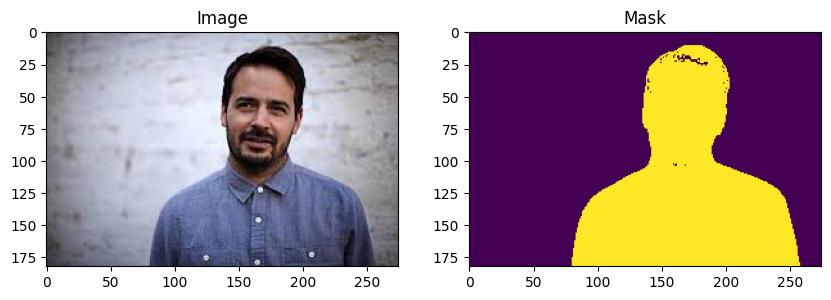

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.set_title('Image')
ax1.imshow(img)
ax2.set_title('Mask')
ax2.imshow(mask)

In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
import albumentations as A

In [ ]:
train_aug = A.Compose(
    [
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.Rotate(limit=40),
    ]
)

test_aug = A.Compose(
    [
        A.Resize(image_size, image_size)
    ]
)

In [ ]:
class SegImgDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentation):
    self.df = df
    self.augmentation = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row['images_new']
    mask_path = row['masks_new']

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentation:
      data = self.augmentation(image = img, mask = mask)
      img = data['image']
      mask = data['mask']

    img = torch.from_numpy(img).permute(2,0,1) / 255
    mask = torch.round(torch.Tensor(mask).permute(2,0,1)/ 255)

    return img, mask

In [ ]:
import random

In [ ]:
rand_arr = np.random.randn(256,123,1)

In [ ]:
rand_arr.shape

(256, 123, 1)

In [ ]:
rand_arr_p = torch.from_numpy(rand_arr).permute(2,0,1)

In [ ]:
rand_arr_p

tensor([[[ 0.2686,  1.0151,  0.9080,  ...,  0.1530,  0.5317, -0.1712],
         [ 0.7566, -0.6451,  0.8376,  ...,  0.4359, -1.2976, -0.9160],
         [ 1.2986,  1.0962, -1.1457,  ..., -1.3601, -0.1246, -1.3352],
         ...,
         [ 1.2951, -0.7933, -0.4317,  ...,  0.7962, -0.5098,  0.2427],
         [-0.6908,  0.2146, -1.4319,  ..., -0.8451,  1.3839,  0.2106],
         [-0.0291,  0.9819, -0.0259,  ..., -0.5071,  0.5721, -0.3142]]],
       dtype=torch.float64)

In [ ]:
rand_arr_p.shape

torch.Size([1, 256, 123])

In [ ]:
# General POV : img shape -> (H, W, CC)
# Tensorflow POV : img shape -> (H,W,CC) : (0, 1, 2)
# Torch/PyTorch POV : img shape -> (CC, H, W) : (2, 0, 1)

In [ ]:
trainset = SegImgDataset(train_df, train_aug)
testset = SegImgDataset(test_df, test_aug)

In [ ]:
trainload = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testload = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [ ]:
def view(img, mask, p_mask = None):
  if p_mask != None:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(img.permute(1,2,0).numpy())
    ax2.imshow(mask.permute(1,2,0).numpy())
    ax3.imshow(p_mask.permute(1,2,0).numpy())

    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Predicted mask')

  else:
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img.permute(1,2,0).numpy())
    ax2.imshow(mask.permute(1,2,0).numpy())

    ax1.set_title('Image')
    ax2.set_title('Mask')

In [ ]:
img, mask = trainset[10]

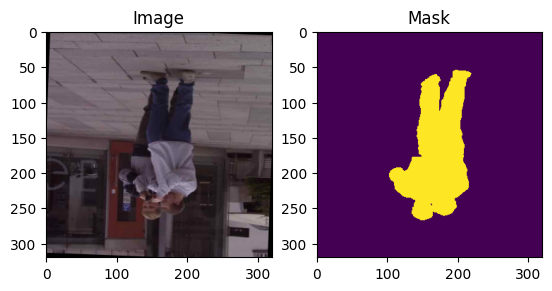

In [ ]:
view(img, mask)

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
# !pip install segmentation_models_pytorch

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
from torch import nn

In [ ]:
class ObjModel(nn.Module):
  def __init__(self):
    super(ObjModel, self).__init__()

    self.logits = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1
    )

  def forward(self, image, gt_masks = None):
    masks = self.logits(image)
    if gt_masks !=None:
      loss1 = DiceLoss(mode='binary')(masks, gt_masks)
      loss2 = nn.BCEWithLogitsLoss()(masks, gt_masks)

      loss = loss1 + loss2

      return masks, loss

    return masks

In [ ]:
model = ObjModel()

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5-c6949ce9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5-c6949ce9.pth
100%|██████████| 117M/117M [00:09<00:00, 12.4MB/s]


In [ ]:
model

ObjModel(
  (logits): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()


In [ ]:
def train_fn(model, dataloader, optimizer):
  tot_loss = 0
  model.train()

  for data in tqdm(dataloader):
    image, gt_masks = data
    optimizer.zero_grad()

    masks, loss = model(image, gt_masks)

    loss.backward()
    optimizer.step()

    tot_loss += loss.item()

  return tot_loss / len(dataloader)

In [ ]:
def test_fn(model, dataloader):
  tot_loss = 0
  model.eval()

  with torch.no_grad():
    for data in tqdm(dataloader):
      image, gt_masks = data

      masks, loss = model(image, gt_masks)

      tot_loss += loss.item()

  return tot_loss / len(dataloader)

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr = lr)

In [ ]:
best_val_loss = np.inf

for i in range(epochs):
  train_loss = train_fn(model, trainload, optimizer)
  test_loss = test_fn(model, testload)

  if test_loss < best_val_loss:
    best_val_loss = test_loss
    torch.save(model.state_dict(), 'best_pts.pt')

  print(f'Epochs {i+1} train loss : {train_loss} test_loss : {test_loss}')

In [ ]:
t_img, gt_t_mask = testset[20]

In [ ]:
t_mask = model(np.expand_dims(t_img, axis = 0))

In [ ]:
pred_mask = torch.sigmoid(t_mask)

In [ ]:
pred_mask = (pred_mask > 0.5)*1.0

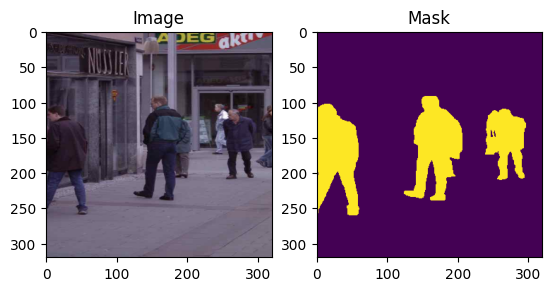

In [ ]:
view(t_img, gt_t_mask, pred_mask)

In [ ]:
def save_mask(mask, path):
  mask = mask.squeeze(0).permute(1,2,0).numpy()
  mask = (mask > 0.5)*1.0
  mask = mask.astype(np.uint8)
  cv2.imwrite(path, mask*255)

In [ ]:
save_mask(pred_mask, 'pred_mask.png')